In [ ]:
!python3 -m pip install --upgrade Pillow

In [ ]:
from gym_robotmimic.EnvRobot import EnvRobot

In [ ]:
import math
import numpy as np
import time
from IPython import display
import random
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

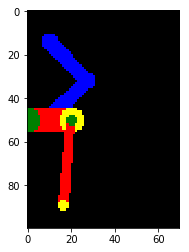

In [3]:
pos = (0, 50)
env = EnvRobot(pos, 
               [(20, 10), (40, 5)], # arm length and width
               [0, 95*math.pi/180]) # initial angles

env.setObservationSpace(70, 100)

env.setGoalRobot(pos, 
                 [(10, 10), (25, 7), (25, 7)], # (arm length and width)
                 #[0,0,0]) # initial angles
                 [0, -45*math.pi/180, -90*math.pi/180]) # initial angles

#env.turn([0, 90*math.pi/180])
img = env.plot(goal=True)

In [4]:
# discretized actions -> functions
def action_plus(env):
    if env.links[1]['angle'] < 90*math.pi/180:
        env.turn([0, 5*math.pi/180])
    
def action_minus(env):
    if env.links[1]['angle'] > -90*math.pi/180:
        env.turn([0, -5*math.pi/180])
        
def action_stay(env):
    return

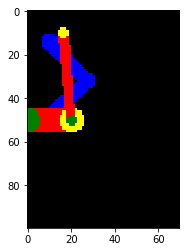

In [5]:
env.reset()
reward = []

r = np.arange(-95, 96, 5)
for i in r:
    action_minus(env)
    reward.append(env.getReward())
    img = env.plot(goal=True)

    time.sleep(0.1)
    display.clear_output(wait=True)
    display.display(img)
display.clear_output(wait=True)

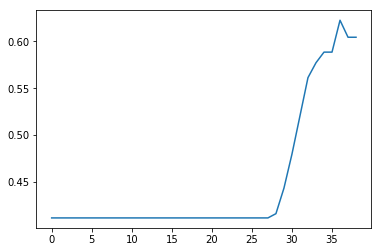

In [6]:
plt.plot(reward)
#plt.savefig('rewards.png')

In [ ]:
############## Initializing #################

# Q-Learning (naive)

# init Q(s,a)
# axis space -90° - +90°; 5° steps -> 36 steps
# s Observation space = goal_axis * quantified(goal state) + axis * quantified(axis state) = (2 + 1) * 36 = 108
# a action space = axis * direction = 1 * 2 = 2

#Q = np.zeros((38, 38, 38, 3)) # | goal axis 1 | goal axis 2 | current axis | actions |
Q = np.zeros((38, 38, 3)) # | goal axis 1 | current axis | actions |

Q_mean = [np.mean(Q)]
Rewards_max = [0]
Rewards_mean = [0]


alpha = 0.1 # alpha
gamma = 0.95 # gamma

show_live = False
env.reset()

In [ ]:
file_string = "Q-{}_{}_{}".format(Q.size, alpha, gamma)

In [ ]:
############### Loading .npz file #############

#np.savez(file_string, Q=Q, Rewards_max=Rewards_max, Rewards_mean=Rewards_mean, Q_mean=Q_mean)
file_dict = np.load(file_string+'.npz')
print(file_dict.files)

Q = file_dict['Q']
Rewards_mean = file_dict['Rewards_mean']
Rewards_max = file_dict['Rewards_max']
Q_mean = file_dict['Q_mean']

print(np.max(Q))
print(np.min(Q))
print(np.mean(Q))

In [ ]:
epsilon = 0.7

In [ ]:
plt.rcParams['figure.figsize'] = [14, 6]
show_live = False

In [ ]:
env.reset()
env.plot(goal=True)

In [ ]:
#%%time # JUPYTER MAGIC to measure runtime
############### Vanilla Q-Learning ###############
# Swipes the goal axis up and down, step by step #
# providing high reward in nearby positions      #
#                                                #
#  IDEA TO USE PROXIMITY FOR FASTER LEARNING     #
##################################################

env.reset()

# Repeat until convergence
for i, rand1 in enumerate(itertools.cycle(range(70, -70, -5) + range(-70, 70, 5))):
    if i > 60*60*2: break # about 2h on my machine
    rewards = []
    robot_goal_state = [0, rand1*math.pi/180]
    
    env.setGoalRobot(pos, 
                 #[(10, 10), (25, 7), (25, 7)], # arm length and width
                 [(10, 10), (50, 7)], # arm length and width
                 robot_goal_state) # initial angles
        
    #Repeat until termination
    for j in range(1, 500):
        # Get state entry
        i0 = int((robot_goal_state[1] + 90*math.pi/180) / (5*math.pi/180)) # goal robot state 1 
        #i1 = int((robot_goal_state[2] + 90*math.pi/180) / (5*math.pi/180)) # goal robot state 2
        i2 = int((env.links[1]['angle'] + 90*math.pi/180) / (5*math.pi/180)) # robot state 1 
        
        #Q_state = Q[i0, i1, i2]
        Q_state = Q[i0, i2]
        #print("{}, {}, {} : {}".format(i0, i1, i2, Q_state)
        
        if random.random() > epsilon:
            # Exploit
            if not all(x == Q_state[0] for x in Q_state):
                #print("exploit")
                a = np.unravel_index(Q_state.argmax(), Q_state.shape)[0] # get the index of the max; hacky unfold tuple
                last_explore_a = None
            else:
                #print("exploit: don't care")
                a = random.choice([0, 1, 2])
        else:
            # Explore
            #print("explore")
            a = random.choice([0, 1, 2])

        
        # Take Action
        if a == 0:
            #print("Action plus")
            action_plus(env)
            if i2 < Q.shape[1]:
                i2_next = i2 + 1
            else:
                i2_next = i2
        elif a == 1:
            #print("Action minus")
            action_minus(env)
            if i2 > 0:
                i2_next = i2 - 1
            else:
                i2_next = i2
        else:
            #print("Action stay")
            action_stay(env)
            i2_next = i2
            
        if show_live:
            img = env.plot(goal=True)
            display.clear_output(wait=True)
            display.display(img)
            #time.sleep(0.1)
        
        # Update Q
        r = env.getReward()
        #Q[i0, i1, i2, a] = (1 - alpha) * Q[i0, i1, i2, a] + alpha * (r + gamma * np.argmax(Q[i0, i1, i2_next]))
        Q[i0, i2, a] = (1 - alpha) * Q[i0, i2, a] + alpha * (r + gamma * np.argmax(Q[i0, i2_next]))
        
        rewards.append(r)
    
    Q_mean = np.append(Q_mean, np.mean(Q))
    Rewards_mean = np.append(Rewards_mean, np.mean(rewards))
    Rewards_max = np.append(Rewards_max, np.max(rewards))
    
    # save every episode
    np.savez(file_string, Q=Q, Rewards_max=Rewards_max, Rewards_mean=Rewards_mean, Q_mean=Q_mean)
    
    if not show_live:
        display.clear_output(wait=True)
        print("Loop: {} with {} steps".format(i, j))
        print("Goal state: {}".format(rand1))
        print("Max Rewards : {}".format(Rewards_max[-1]))
        print("Mean Rewards: {}".format(Rewards_mean[-1]))
        print("Mean Q: {}".format(Q_mean[-1]))

        plt.plot(Rewards_max)
        plt.plot(Rewards_mean)
        plt.plot(Q_mean)
        plt.legend(["max reward", "mean reward", "mean Q"])
        plt.show()

In [ ]:
#%%time # JUPYTER MAGIC to measure runtime
############### Vanilla Q-Learning ###############
# Random goal axis                               #
# Random starting position                       #
#                                                #
##################################################


# Repeat until ...
for i in range(1, 60*60*2):
    #env.reset()
    rewards = []
    rand1 = random.randrange(-70, 75, 5)
    #rand2 = random.randrange(-90, 95, 5)
    #robot_goal_state = [0, rand1*math.pi/180, rand2*math.pi/180]
    robot_goal_state = [0, rand1*math.pi/180]
    
    env.setGoalRobot(pos, 
                 #[(10, 10), (25, 7), (25, 7)], # arm length and width
                 [(10, 10), (50, 7)], # arm length and width
                 robot_goal_state) # initial angles
        
    for j in range(1, 500):
        # Get state entry
        i0 = int((robot_goal_state[1] + 90*math.pi/180) / (5*math.pi/180)) # goal robot state 1 
        #i1 = int((robot_goal_state[2] + 90*math.pi/180) / (5*math.pi/180)) # goal robot state 2
        i2 = int((env.links[1]['angle'] + 90*math.pi/180) / (5*math.pi/180)) # robot state 1 
        
        #Q_state = Q[i0, i1, i2]
        Q_state = Q[i0, i2]
        
        if random.random() > epsilon:
            # Exploit
            if not all(x == Q_state[0] for x in Q_state):
                #print("exploit")
                a = np.unravel_index(Q_state.argmax(), Q_state.shape)[0] # get the index of the max; hacky unfold tuple
            else:
                #print()"exploit: don't care")
                a = random.choice([0,1,2])
        else:
            # Explore
            #print("explore")
            a = random.choice([0,1,2])

        # Take Action
        if a == 0:
            #print("Action plus")
            action_plus(env)
            if i2 < Q.shape[1]:
                i2_next = i2 + 1
            else:
                i2_next = i2
        elif a == 1:
            #print("Action minus")
            action_minus(env)
            if i2 > 0:
                i2_next = i2 - 1
            else:
                i2_next = i2
        else:
            #print("Action stay")
            action_stay(env)
            i2_next = i2
            
        if show_live:
            img = env.plot(goal=True)
            display.clear_output(wait=True)
            display.display(img)
            #time.sleep(0.1)
        
        # Update Q
        r = env.getReward()
        #Q[i0, i1, i2, a] = (1 - alpha) * Q[i0, i1, i2, a] + alpha * (r + gamma * np.argmax(Q[i0, i1, i2_next]))
        Q[i0, i2, a] = (1 - alpha) * Q[i0, i2, a] + alpha * (r + gamma * np.argmax(Q[i0, i2_next]))

        rewards.append(r)

    Q_mean = np.append(Q_mean, np.mean(Q))
    Rewards_mean = np.append(Rewards_mean, np.mean(rewards))
    Rewards_max = np.append(Rewards_max, np.max(rewards))
    
    #save every episode
    np.savez(file_string, Q=Q, Rewards_max=Rewards_max, Rewards_mean=Rewards_mean, Q_mean=Q_mean)
    
    if not show_live:
        display.clear_output(wait=True)
        print("Loop: {} with {} steps".format(i, j))
        print("Goal state: {}".format(rand1))
        print("Max Rewards : {}".format(Rewards_max[-1]))
        print("Mean Rewards: {}".format(Rewards_mean[-1]))
        print("Mean Q: {}".format(Q_mean[-1]))

        #print("Std Rewards", np.std(rewards))
        plt.plot(Rewards_max)
        plt.plot(Rewards_mean)
        plt.plot(Q_mean)
        plt.legend(["max reward", "mean reward", "mean Q"])
        plt.show()

In [ ]:
np.savez("bck_"+file_string, Q=Q, Rewards_max=Rewards_max, Rewards_mean=Rewards_mean, Q_mean=Q_mean)